# Applied Data Science - Capstone Project

## Install required Python packages

In [14]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium --yes 
!conda install -c conda-forge pyquery --yes
!conda install -c conda-forge geocoder --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    conda-4.5.11               |           py35_0         636 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    certifi-2018.8.24          |           py35_1         138 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0             conda-forge
    geopy:       

In [ ]:
!conda install -c conda-forge seaborn --yes

## Get Wiki page containing Toronto Boroughs/Neighborhoods
### Note: using pandas.io.hmtl to get the wiki table into pandas DataFrame

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto = pd.read_html(str(wikitables[0]), index_col=None, header=0)[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [2]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

## Alternative way to read in the content and produce a dataframe using pandas.io.html
### Note: Results are consistent between the two methods

In [3]:
import requests
import numpy as np
import pandas as pd
from pandas.io.html import read_html

# Define the wiki page url var
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
# Issue HTTP request to get the URL content
req = requests.get(WIKI_URL)
# Use pandas read_html to read in the content
wikitables = read_html(WIKI_URL, index_col=None, header=0, attrs={"class":["sortable","wikitable"]})
# Get pandas dataframe
Toronto = wikitables[0]
Toronto.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
# TO VERIFY THAT BOTH METHODS PRODUCE SIMILAR DIMENSIONS
Toronto.shape

(289, 3)

## Data cleansing

In [5]:
# Empty entries to np.nan to drop them in the next step
Toronto['Borough'].replace('', np.nan, inplace=True)
# Drop np.nan to remove rows not containing meaningful data
Toronto.dropna(subset=['Borough'], inplace=True)
# Leave behind rows containing 'Not assigned' in 'Borough'
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']

## Data processing - 'Not assigned' to value

In [6]:
# Iterate over the dataframe and fix 'Not assigned' for column 'Neighborhood'
for i, _ in Toronto.iterrows():
    if Toronto.loc[i]['Neighbourhood'] == 'Not assigned': Toronto.loc[i]['Neighborhood'] = Toronto.loc[i]['Borough']

## Dataframe shape

In [7]:
# Check datafame shape
Toronto.shape

(212, 3)

## Number of rows in the dataframe

In [8]:
# Print the number of rows in the dataframe
print('Number of rows in Toronto dataframe: {}'.format(Toronto.shape[0]))

Number of rows in Toronto dataframe: 212


## API compensator - at times geocoder.google returns None for the same postal code
### Create a dictionary of all the postal codes to add to the dictionary at the next step

In [9]:
TPS = Toronto['Postcode'].unique()
len(TPS)

103

## Get offline cache to support throttled Geocoder API

In [10]:
!wget -q --no-check-certificate -O 'latitude.pickle' 'https://docs.google.com/uc?export=download&id=1PdEOkPErrpBtDgSlDwczIv_KLlpY-YcO'
!wget -q --no-check-certificate -O 'longitude.pickle' 'https://docs.google.com/uc?export=download&id=1XujA04dCARQnlxu-X2ItOVcYQz0MMQh9'

In [11]:
!ls -l *.pickle

-rw-rw-r-- 1 unixdev unixdev 1965 Sep 14 13:47 latitude.pickle
-rw-rw-r-- 1 unixdev unixdev 1965 Sep 14 13:47 longitude.pickle


In [12]:
import pickle

with open('latitude.pickle', 'rb') as flat:
    latitude = pickle.load(flat)
with open('longitude.pickle', 'rb') as flon:
    longitude = pickle.load(flon)

In [13]:
import geocoder
import time

for postcode in TPS:
    # When offline cache is available use it to avoid Geocoder Google API throttling
    if postcode in latitude.keys(): 
        continue
    while True:
        g = geocoder.google('{}, Toronto, Ontario'.format(postcode))
        lat_lng_coords = g.latlng
        if lat_lng_coords == None:
            print('Trottled response to {}'.format(postcode))
            time.sleep(5)
            continue
        break
    
    if lat_lng_coords != None:
        latitude[postcode] = lat_lng_coords[0]
        longitude[postcode] = lat_lng_coords[1]
print('Successfully populated geo locations')

Successfully populated geo locations


In [14]:
lat = []
lon = []
for i, _ in Toronto.iterrows():
    lat.append(latitude[Toronto.loc[i]['Postcode']])
    lon.append(longitude[Toronto.loc[i]['Postcode']])
                        

In [15]:
Toronto = Toronto.assign(Latitude = lat, Longitude=lon)
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [16]:
Toronto.shape

(212, 5)

In [18]:
Toronto = Toronto.reset_index(drop=True)
Toronto.to_csv('Toronto.csv')
Toronto.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
6,M7A,Queen's Park,Not assigned,43.662301,-79.389494
7,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
8,M1B,Scarborough,Rouge,43.806686,-79.194353
9,M1B,Scarborough,Malvern,43.806686,-79.194353


## Additional imports

In [125]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Import Demographics Data

### Pull the data from Wikipedia

In [38]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

res = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
soup = BeautifulSoup(res.content,'lxml')
wikitables = soup.find_all('table') 
Toronto_Demographics = pd.read_html(str(wikitables[1]), index_col=None, header=0)[0]

In [39]:
Toronto_Demographics.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [40]:
df_dens = pd.DataFrame(Toronto_Demographics[['Name','Land area (km2)', 'Average Income', 'Density (people/km2)', 'Population', '% Change in Population since 2001']])
df_dens.drop([0], inplace=True)
df_dens.rename(columns={'% Change in Population since 2001': 'Change'}, inplace=True)
df_dens = df_dens.reset_index(drop=True)
df_dens.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_dens.head()

,Land area (km2),Average Income,Density (people/km2),Population,Change
Name,,,,,
Agincourt,12.45,25750,3580,44577,4.6
Alderwood,4.94,35239,2360,11656,-4.0
Alexandra Park,0.32,19687,13609,4355,0.0
Allenby,0.58,245592,4333,2513,-1.0
Amesbury,3.51,27546,4934,17318,1.1


In [41]:
df_dens['Change'] = df_dens['Change'].apply(lambda x: x * 1000)

<Figure size 432x288 with 0 Axes>

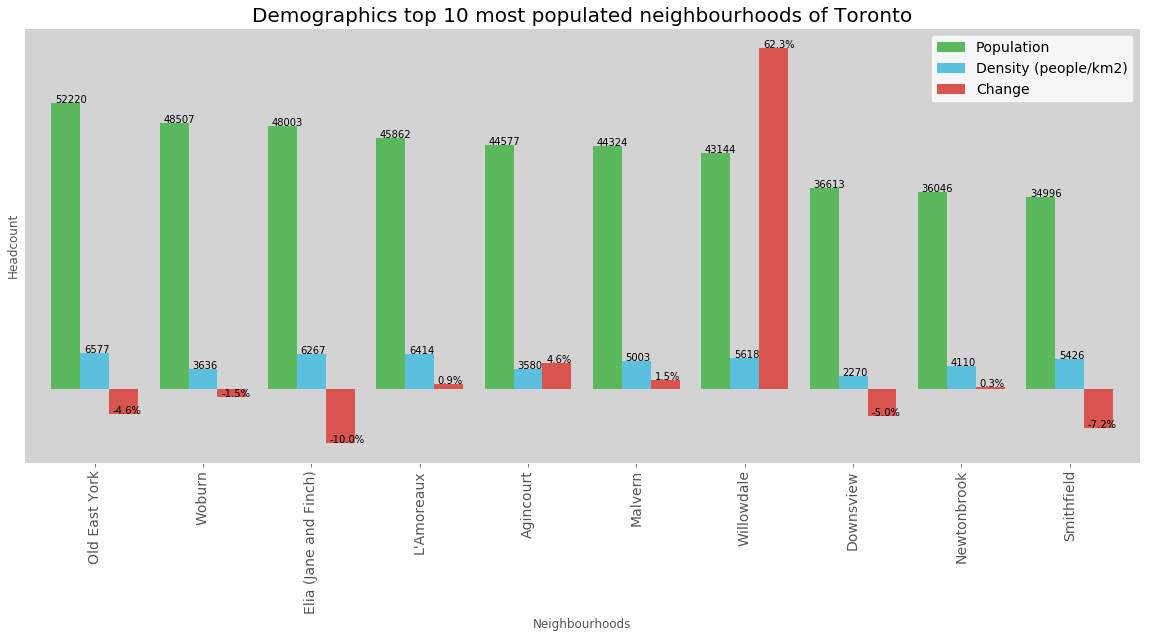

In [42]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_dens.sort_values(['Population', 'Density (people/km2)'], ascending=False)
ax = df_dens[['Population', 'Density (people/km2)', 'Change']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('Demographics top 10 most populated neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=19 else (b.y1 + b.y0)/1000)
    if n > 19:
        val += '%'
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

In [43]:
import re
df_ai = pd.DataFrame(Toronto_Demographics[['Name','Average Income']])
df_ai.drop([0], inplace=True)
df_ai = df_ai.reset_index(drop=True)
df_ai.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_ai.head()
df_ai['Average Income'] = df_ai['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ai['Average Income'].dtype

dtype('int64')

In [44]:
df_ai['Average Income'].values

array([ 25750,  35239,  19687, 245592,  27546, 116651,  92319,  34169,
        40598,  46752,  41485,  80827,  29723,  48965,  55578,  41605,
        27156, 314107,  27260,  50398, 103703,  23301,  82203,  34867,
        81288,  30556,  37653,  26610,  33392,  38182,  32701,  54681,
        23021, 104362,  28335,  55735,  80704,  41998,  40617,  47515,
        30442,  26525,  28311,  26751,  27961,  26672,  33847,  36206,
        25307,  22691,  34789,  28403,  63282,  63952,  23471, 101631,
        46086,  37614,  35022, 129904,  35277,  23350,  40806,  45792,
        69232,  22136,  56395,  46437,  33640,  33465, 222560,  39186,
        39738,  26117,  80618,  30907,  24297,  29576,  40404,  25078,
        43570,  28067,  23335,  32004,  30920,  26375,  46631,  29867,
        36361, 214110,  82670,  83853,  30886,  31231,  29224,  37288,
       127356,  25677,  27611,  51695,  30944,  25243,  47011, 154825,
        27139,  23910,  33415,  33428,  44611,  34330,  21155,  33517,
      

<Figure size 432x288 with 0 Axes>

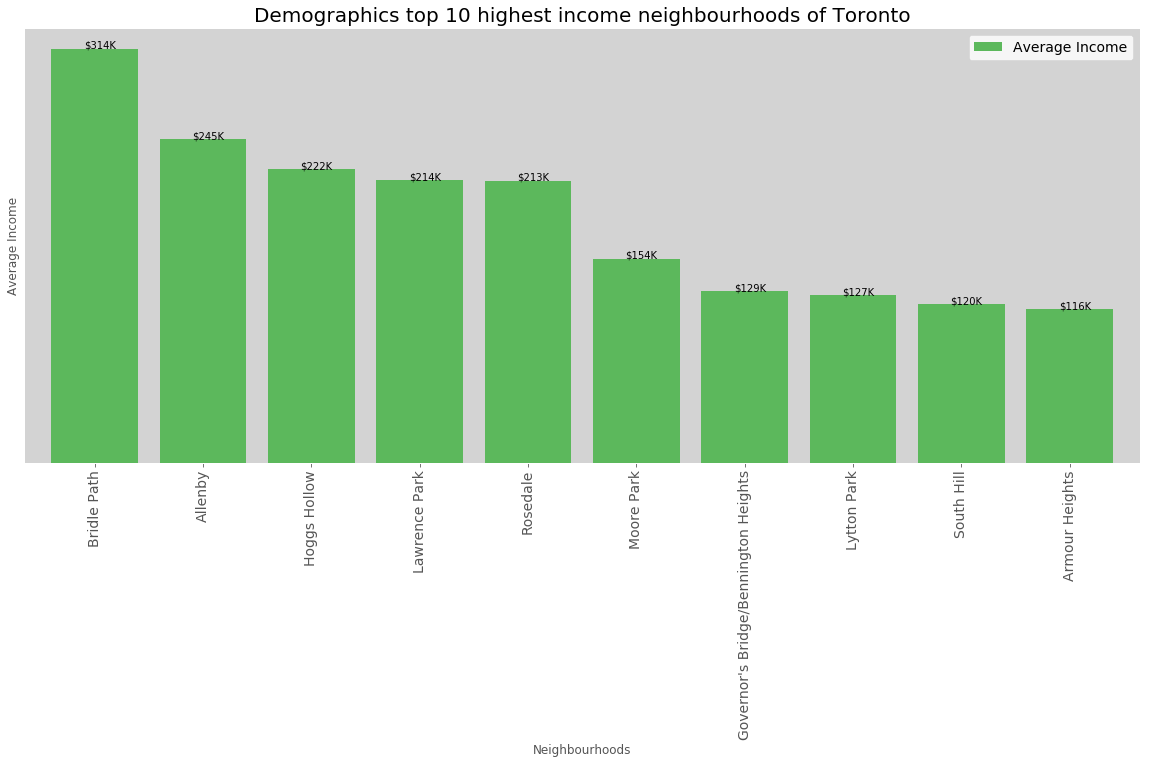

In [45]:
mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_ai = df_ai.sort_values(['Average Income'], ascending=False)
ax = df_ai[['Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Demographics top 10 highest income neighbourhoods of Toronto', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5,1,'Average Income 10 top neighbourhoods in the city of Toronto')

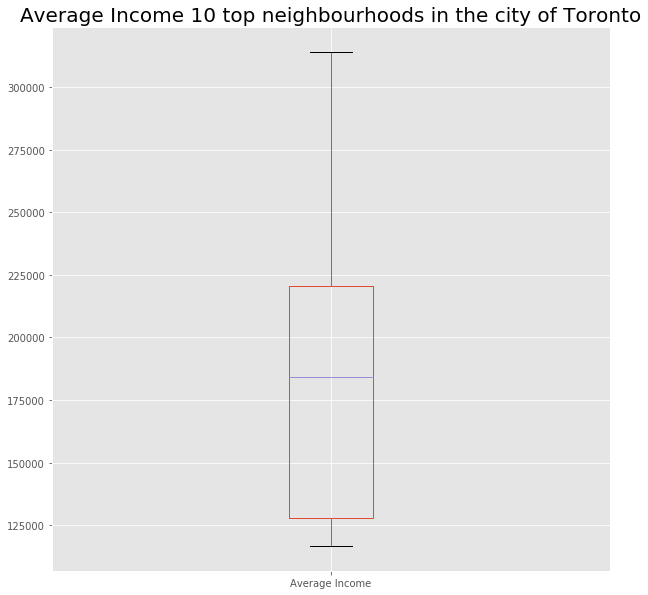

In [46]:
df_ai[['Average Income']][:10].plot.box(figsize=(10,10))
plt.title('Average Income 10 top neighbourhoods in the city of Toronto', fontsize=20)

Text(0.5,1,'Average Income - Toronto')

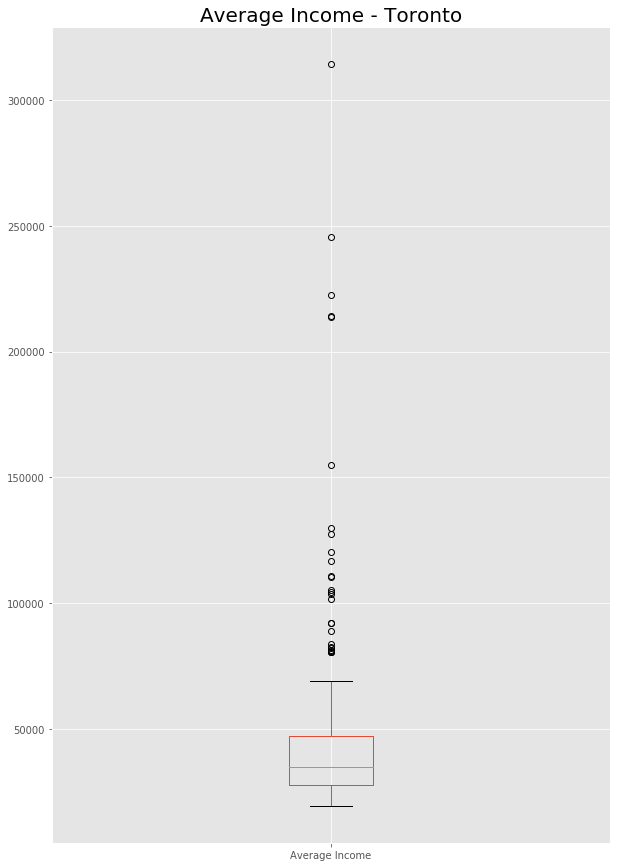

In [47]:
df_ai.plot.box(figsize=(10, 15))
plt.title('Average Income - Toronto', fontsize=20)

In [48]:
import re
df_ip = pd.DataFrame(Toronto_Demographics[['Average Income', 'Population']])
df_ip.drop([0], inplace=True)
#df_ip = df_ai.reset_index(drop=True)
#df_ai.set_index(['Name'], inplace=True)
#df_dens.apply(pd.to_numeric, errors='ignore')
df_ip.head()
df_ip['Average Income'] = df_ip['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_ip['Population'] = df_ip['Population'].apply(lambda x: int(x))
df_ip = df_ip.sort_values(['Population'])
df_ip = df_ip.reset_index(drop=True)
df_ip

,Average Income,Population
0,63952,548
1,36243,571
2,43344,627
3,314107,1540
4,129904,2112
5,245592,2513
6,36652,2719
7,56395,2790
8,222560,3123
9,22136,3375


Text(0.5,1,'Average Income - Population in the city of Toronto')

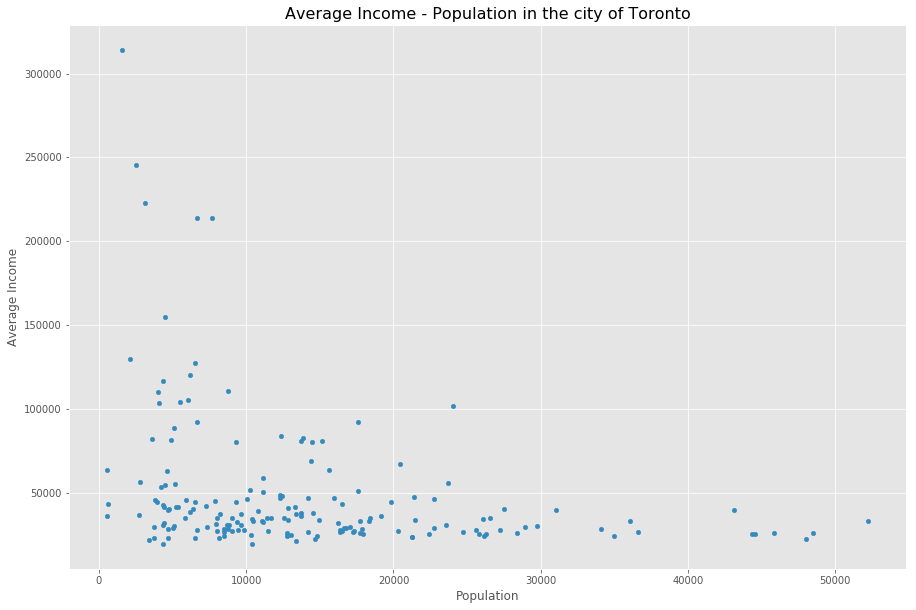

In [49]:
df_ip.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Average Income - Population in the city of Toronto', fontsize=16)

### Post process the dataframe Toronto_Demographics

In [50]:
columns_to_drop = [
    'FM', 
    'Census Tracts', 
    '% Change in Population since 2001', 
    'Land area (km2)', 
    'Transit Commuting\xa0%', 
    '% Renters', 
    'Second most common language (after English) by name', 
    'Map'
]

Toronto_Demographics.drop(columns=columns_to_drop, inplace=True)

Toronto_Demographics = Toronto_Demographics.rename(columns={'Second most common language (after English) by percentage':'ESL'})
Toronto_Demographics = Toronto_Demographics.rename(columns={'Name':'Neighbourhood'})
Toronto_Demographics.drop([0], inplace=True)

Toronto_Demographics.head()
Toronto_Demographics['Percentage'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[0],axis=1)
Toronto_Demographics['Language'] = Toronto_Demographics.apply (lambda row: row['ESL'].split('% ')[1],axis=1)
Toronto_Demographics.drop(columns=['ESL'], inplace=True)

### Show post processed result on Toronto_Demographics

In [51]:
Toronto_Demographics.head(10)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
3,Alexandra Park,4355,13609,19687,17.9,Cantonese
4,Allenby,2513,4333,245592,01.4,Russian
5,Amesbury,17318,4934,27546,06.1,Spanish
6,Armour Heights,4384,1914,116651,09.4,Russian
7,Banbury,6641,2442,92319,05.1,Unspecified Chinese
8,Bathurst Manor,14945,3187,34169,09.5,Russian
9,Bay Street Corridor,4787,43518,40598,09.6,Mandarin
10,Bayview Village,12280,2966,46752,08.4,Cantonese


In [52]:
Toronto_Demographics.shape

(174, 6)

In [53]:
df1 = pd.DataFrame(Toronto_Demographics[Toronto_Demographics['Language'].isin(['Russian', 'Ukrainian'])])
df1.reset_index(drop=True)
df1 = df1.set_index(['Neighbourhood'])
df1

,Population,Density (people/km2),Average Income,Percentage,Language
Neighbourhood,,,,,
Allenby,2513,4333,245592,01.4,Russian
Armour Heights,4384,1914,116651,09.4,Russian
Bathurst Manor,14945,3187,34169,09.5,Russian
Bloor West Village,5175,6993,55578,03.6,Ukrainian
Branson,8017,6414,27156,24.1,Russian
Deer Park,15165,10387,80704,01.1,Russian
Forest Hill,24056,5530,101631,02.4,Russian
Humber Bay Shores,10775,7588,39186,05.2,Russian
Humber Valley Village,14453,2652,80618,03.9,Ukrainian


In [54]:
df_td_ru = pd.DataFrame(Toronto_Demographics[Toronto_Demographics['Language'].isin(['Russian', 'Ukrainian'])])
df_td_ru.reset_index(drop=True)
df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru['Percentage'] = df_td_ru['Percentage'].apply(lambda x: float(x))
df_td_ru['Average Income'] = df_td_ru['Average Income'].apply(lambda x: 
                                                        (lambda match: 
                                                         int(match.group(1).replace(',','')) 
                                                         if match else 
                                                         int(x))(re.search(r'([\d\,]+)(Canada.*)', x)))
df_td_ru['Population'] = df_td_ru['Population'].apply(lambda x: int(x))
df_td_ru['RUK'] = df_td_ru.apply(lambda x: int(x['Population'] * x['Percentage'] / 100), axis=1)
df_td_ru = df_td_ru.sort_values(['RUK'], ascending=False)
df_td_ru = df_td_ru.reset_index()
# df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru = df_td_ru.set_index(['Neighbourhood'])
df_td_ru

,Population,Density (people/km2),Average Income,Percentage,Language,RUK
Neighbourhood,,,,,,
Westminster,16386,6914,27826,31.4,Russian,5145
Newtonbrook,36046,4110,33428,8.8,Russian,3172
Branson,8017,6414,27156,24.1,Russian,1932
Bathurst Manor,14945,3187,34169,9.5,Russian,1419
Westmount,5857,5932,35183,10.6,Ukrainian,620
Forest Hill,24056,5530,101631,2.4,Russian,577
Humber Valley Village,14453,2652,80618,3.9,Ukrainian,563
Humber Bay Shores,10775,7588,39186,5.2,Russian,560
Armour Heights,4384,1914,116651,9.4,Russian,412


<Figure size 432x288 with 0 Axes>

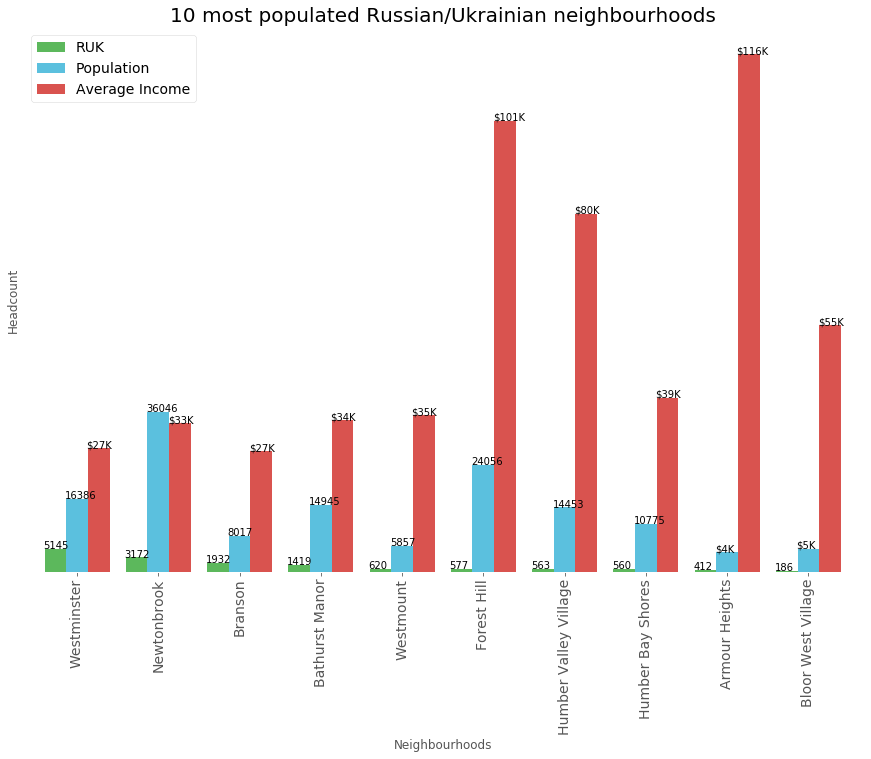

In [55]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c', '#5bc0de', '#d9534f']
df_dens = df_td_ru
# df_dens['Average Income'] = df_dens['Average Income'].apply(lambda x: int(x/10))
ax = df_dens[['RUK', 'Population', 'Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(15, 10), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('white')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Headcount')
plt.title('10 most populated Russian/Ukrainian neighbourhoods', fontsize=20)
x_offset = -0.15
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0) if n <=17 else '$' + str(int((b.y1+b.y0)/1000))+'K')
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

Text(0.5,1,'Russian/Ukrainian Population Average Income - Toronto')

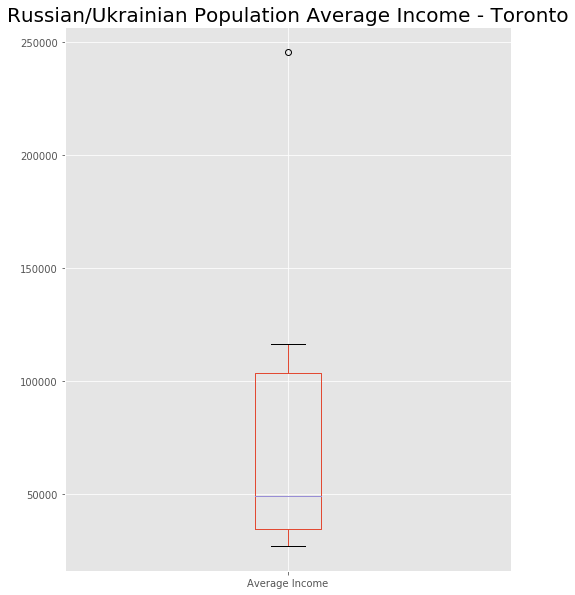

In [56]:
ru_avg_inc = df_td_ru[['Average Income']]
ru_avg_inc.plot.box(figsize=(8, 10))
plt.title('Russian/Ukrainian Population Average Income - Toronto', fontsize=20)

Text(0.5,1,'Russian Population Average Income - Population in the city of Toronto')

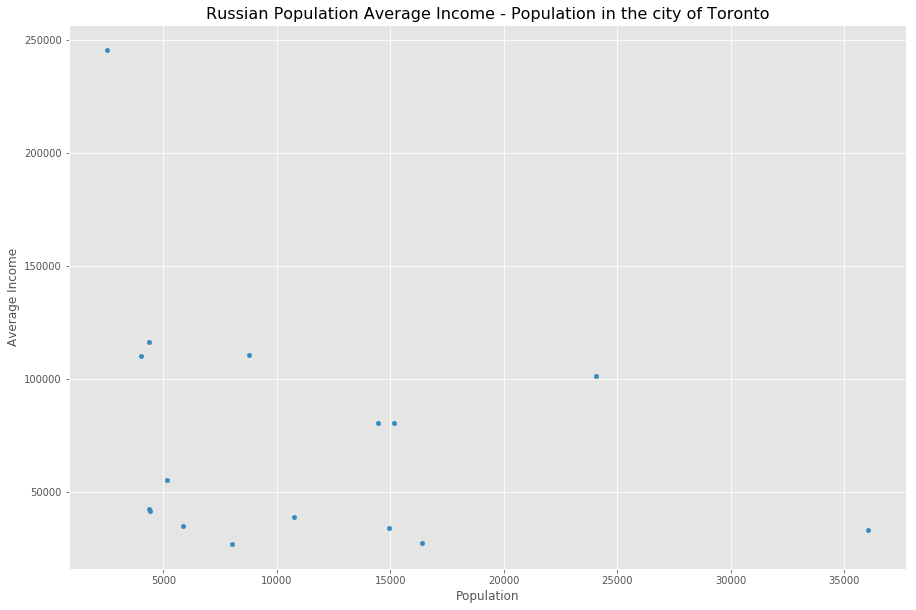

In [57]:
ru_avg = df_td_ru[['Population', 'Average Income']]
ru_avg.plot.scatter(x='Population', y='Average Income', figsize=(15,10))
plt.title('Russian Population Average Income - Population in the city of Toronto', fontsize=16)

<Figure size 432x288 with 0 Axes>

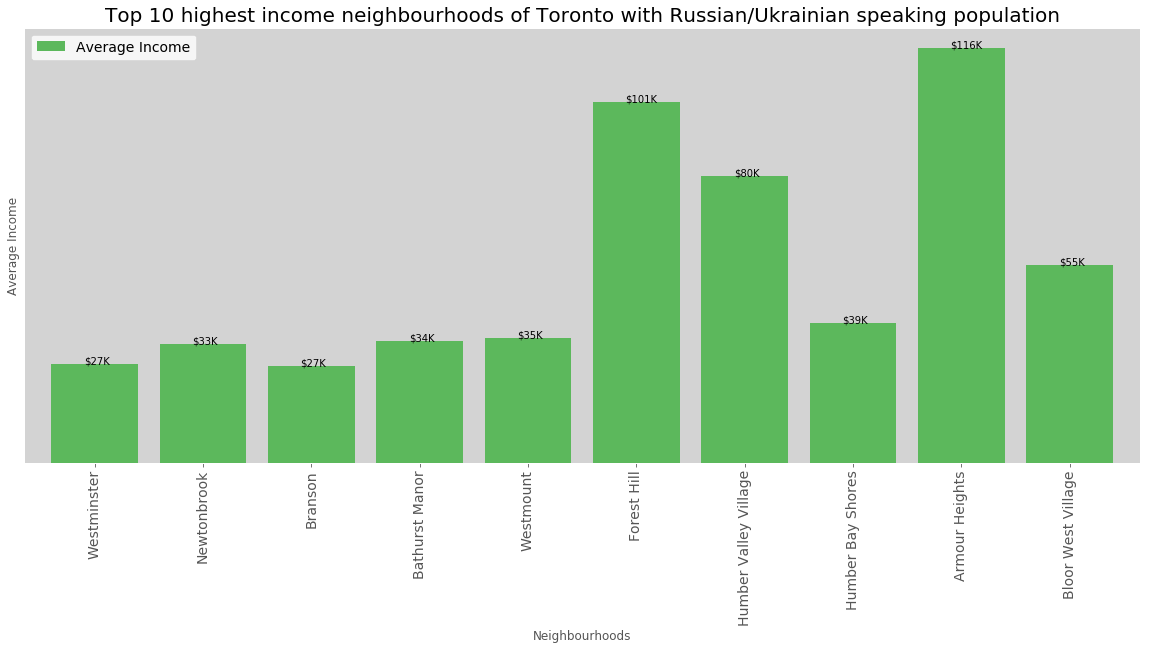

In [58]:
mpl.style.use(['ggplot'])

fig = plt.figure()
ax = fig.add_subplot()
colors = ['#5cb85c']
df_avg = ru_avg.sort_values(['Average Income'], ascending=False)
ax = ru_avg[['Average Income']][:10].plot(kind='bar', grid=False, color=colors, figsize=(20, 8), legend=True, fontsize=14, width=0.8)
ax.set_facecolor('lightgray')
legend = plt.legend(frameon = 1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xlabel('Neighbourhoods')
plt.ylabel('Average Income')
plt.title('Top 10 highest income neighbourhoods of Toronto with Russian/Ukrainian speaking population', fontsize=20)
x_offset = -0.1
y_offset = 2
for n, p in enumerate(ax.patches):
    b = p.get_bbox()
    val = "${}K".format(int((b.y1 + b.y0)/1000))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

### Explore the demographics data for the city of Toronto

In [59]:
list_of_neighbourhoods = Toronto_Demographics['Neighbourhood'].values.tolist()

In [60]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


### Check the neighbourhoods not present in the dataframe Toronto and remove them from the dataframe Toronto_Demographics

In [61]:
list_missing_neigh = []
for neigh in list_of_neighbourhoods:
    if neigh not in Toronto['Neighbourhood'].values and neigh not in Toronto['Borough']:
        list_missing_neigh.append(neigh)
list_missing_neigh

['Alexandra Park',
 'Allenby',
 'Amesbury',
 'Armour Heights',
 'Banbury',
 'Bay Street Corridor',
 'Bayview Woods – Steeles',
 'Bendale',
 'Bloor West Village',
 'Bracondale Hill',
 'Branson',
 'Bridle Path',
 'Caribou Park',
 'Carleton Village',
 'Casa Loma',
 'Centennial',
 'Chaplin Estates',
 'Christie Pits',
 'Clairville',
 'Corktown',
 'Crescent Town',
 'Cricket Club',
 'Davenport',
 'Discovery District',
 'Distillery District/West Don Lands',
 'Don Mills',
 'Don Valley Village',
 'Dovercourt Park',
 'Downsview',
 'Dufferin Grove',
 'Earlscourt',
 'East Danforth',
 'Eatonville',
 'Eglinton East',
 'Elia (Jane and Finch)',
 'Fairbank',
 'Fashion District',
 'Financial District',
 'Forest Hill',
 'Fort York/Liberty Village',
 'Glen Park',
 "Governor's Bridge/Bennington Heights",
 'Graydon Hall',
 'Guildwood',
 'Harbord Village',
 'Harbourfront / CityPlace',
 'Harwood',
 'High Park North',
 'Hillcrest',
 'Hoggs Hollow',
 'Humber Heights',
 'Humber Valley Village',
 'Humbermede',
 'H

In [62]:
Toronto_Demographics = Toronto_Demographics[~Toronto_Demographics.Neighbourhood.isin(list_missing_neigh)]

In [63]:
Toronto_Demographics.reset_index(drop=True)

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
0,Agincourt,44577,3580,25750,19.3,Cantonese
1,Alderwood,11656,2360,35239,06.2,Polish
2,Bathurst Manor,14945,3187,34169,09.5,Russian
3,Bayview Village,12280,2966,46752,08.4,Cantonese
4,Bedford Park,13749,6057,80827,00.7,Greek
5,Birch Cliff,12266,3525,48965,00.9,Unspecified Chinese
6,Brockton,9039,8217,27260,19.9,Portuguese
7,Cabbagetown,11120,7943,50398,01.6,Unspecified Chinese
8,Church and Wellesley,13397,24358,37653,01.8,Spanish
9,Clairlea,11104,3102,33392,04.3,Filipino


### Drop entries from the dataframe Toronto that are not in the dataframe Toronto_Demographics

In [64]:
list_exist_neigh_dem = Toronto_Demographics['Neighbourhood'].values.tolist()

In [65]:
Toronto = Toronto[Toronto.Neighbourhood.isin(list_exist_neigh_dem)]
Toronto.reset_index(drop=True)
Toronto.shape

(77, 5)

In [66]:
Toronto_Demographics.shape

(76, 6)

In [67]:
Toronto_Demographics.head()

,Neighbourhood,Population,Density (people/km2),Average Income,Percentage,Language
1,Agincourt,44577,3580,25750,19.3,Cantonese
2,Alderwood,11656,2360,35239,06.2,Polish
8,Bathurst Manor,14945,3187,34169,09.5,Russian
10,Bayview Village,12280,2966,46752,08.4,Cantonese
12,Bedford Park,13749,6057,80827,00.7,Greek


In [68]:
Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
4,M6A,North York,Lawrence Heights,43.718518,-79.464763
5,M6A,North York,Lawrence Manor,43.718518,-79.464763
8,M1B,Scarborough,Rouge,43.806686,-79.194353


### Merge the two dataframes to create a workabable dataframe - Toronto_Merged

In [69]:
Toronto_Merged = pd.merge(Toronto, Toronto_Demographics, on='Neighbourhood')

In [70]:
Toronto_Merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil


### Remove duplicate entries from the dataframe Toronto_Merged

In [71]:
Toronto_Merged.drop_duplicates(keep='first', inplace=True)

In [72]:
Toronto_Merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M3A,North York,Parkwoods,43.753259,-79.329656,26533,5349,34811,03.4,Unspecified Chinese
1,M4A,North York,Victoria Village,43.725882,-79.315572,17047,3612,29657,03.2,Urdu
2,M6A,North York,Lawrence Heights,43.718518,-79.464763,3769,1178,29867,15.0,Italian
3,M6A,North York,Lawrence Manor,43.718518,-79.464763,13750,6425,36361,07.2,Filipino
4,M1B,Scarborough,Rouge,43.806686,-79.194353,22724,791,29230,15.6,Tamil
5,M1B,Scarborough,Malvern,43.806686,-79.194353,44324,5003,25677,12.2,Tamil
6,M5B,Downtown Toronto,Garden District,43.657162,-79.378937,8240,15846,37614,03.0,Unspecified Chinese
7,M9B,Etobicoke,Princess Gardens,43.650943,-79.554724,9288,2249,80607,02.4,Korean
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
9,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12853,2505,33640,05.1,Tamil


In [73]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
T_lat = location.latitude
T_lon = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(T_lat, T_lon))

/home/unixdev/anaconda3/lib/python3.6/site-packages/geopy/geocoders/osm.py:138: UserWarning: Using Nominatim with the default "geopy/1.16.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


# Create a map of Toronto with neighbourhoods

In [74]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

# Prepare Foursquare credentials

In [75]:
CLIENT_ID = '0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD'
CLIENT_SECRET = 'MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD
CLIENT_SECRET:MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3


## Create a new dataframe targeting a specific ethnic group - Russian/Ukrainian

In [116]:
df_uk = Toronto_Merged[Toronto_Merged.Language.isin(['Russian','Ukrainian'])]
df_uk = df_uk.sort_values(by=['Percentage','Population'], ascending=False)
df_uk.reset_index(drop=True)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
0,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian
1,M3H,North York,Bathurst Manor,43.754328,-79.442259,14945,3187,34169,09.5,Russian
2,M2M,North York,Newtonbrook,43.789053,-79.408493,36046,4110,33428,08.8,Russian
3,M8V,Etobicoke,Humber Bay Shores,43.605647,-79.501321,10775,7588,39186,05.2,Russian
4,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
5,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian
6,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian
7,M4V,Central Toronto,Deer Park,43.686412,-79.400049,15165,10387,80704,01.1,Russian


In [79]:
T_map = folium.Map(location=[T_lat, T_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_uk['Latitude'], df_uk['Longitude'], df_uk['Borough'], df_uk['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(T_map)  
    
T_map

### Get a neighbourhood with the highest number of people with Russian/Ukrainian background

In [80]:
uk_lat = df_uk['Latitude'].values[0] # neighborhood latitude value
uk_lon = df_uk['Longitude'].values[0] # neighborhood longitude value
uk_name = df_uk['Neighbourhood'].values[0] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(uk_name, 
                                                               uk_lat, 
                                                               uk_lon))

Latitude and longitude values of Westmount are 43.696319, -79.5322424.


### Prepare Foursquare URL

In [81]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    uk_lat, 
    uk_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0C4ANZOALOMRDOJZU2BUYUKB2LOF3N5ADH4A3WJ3UDS3YIJD&client_secret=MIJAG0GZX3JF2RXLGPCOOH25QZ3NBF2MLFYQJUG2DD5LCNM3&v=20180605&ll=43.696319,-79.5322424&radius=500&limit=100'

### Issue a Foursquare request

In [82]:
results = requests.get(url).json()
# results
if results != None:
    print("Request successfully processed")

Request successfully processed


In [83]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [84]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.696249,-79.533117
1,Mayflower Chinese Food,Chinese Restaurant,43.692753,-79.531566
2,Pizza Hut,Pizza Place,43.696431,-79.533233
3,Subway,Sandwich Place,43.692927,-79.531471
4,Pizza Nova,Pizza Place,43.692817,-79.531570


In [85]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [89]:
# type your answer here
uk_venues = getNearbyVenues(names=df_uk['Neighbourhood'],
                                   latitudes=df_uk['Latitude'],
                                   longitudes=df_uk['Longitude']
                                  )

Westmount
Bathurst Manor
Newtonbrook
Humber Bay Shores
West Deane Park
Runnymede
The Kingsway
Deer Park


In [90]:
print(uk_venues.shape)
uk_venues.head()

(93, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Westmount,43.696319,-79.532242,Starbucks,43.696249,-79.533117,Coffee Shop
1,Westmount,43.696319,-79.532242,Mayflower Chinese Food,43.692753,-79.531566,Chinese Restaurant
2,Westmount,43.696319,-79.532242,Pizza Hut,43.696431,-79.533233,Pizza Place
3,Westmount,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place
4,Westmount,43.696319,-79.532242,Pizza Nova,43.692817,-79.531570,Pizza Place


### Get count of venues in the neighbourhoods with the highest population of Russians

In [91]:
uk_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bathurst Manor,18,18,18,18,18,18
Deer Park,14,14,14,14,14,14
Humber Bay Shores,15,15,15,15,15,15
Newtonbrook,1,1,1,1,1,1
Runnymede,35,35,35,35,35,35
The Kingsway,2,2,2,2,2,2
West Deane Park,1,1,1,1,1,1
Westmount,7,7,7,7,7,7


In [92]:
print('There are {} uniques categories.'.format(len(uk_venues['Venue Category'].unique())))

There are 54 uniques categories.


### Perform one-hot encoding on the venues

In [93]:
# one hot encoding
uk_onehot = pd.get_dummies(uk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
uk_onehot['Neighborhood'] = uk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [uk_onehot.columns[-1]] + list(uk_onehot.columns[:-1])
uk_onehot = uk_onehot[fixed_columns]

uk_onehot.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bookstore,Bridal Shop,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy,Pizza Place,Playground,Pool,Pub,Restaurant,River,Sandwich Place,Shopping Mall,Smoothie Shop,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant
0,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Westmount,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Westmount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
uk_onehot.shape

(93, 55)

### Group the venues by neighbourhoods with Ukrainians

In [95]:
uk_grouped = uk_onehot.groupby('Neighborhood').mean().reset_index()
uk_grouped

,Neighborhood,American Restaurant,Arts & Crafts Store,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bookstore,Bridal Shop,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy,Pizza Place,Playground,Pool,Pub,Restaurant,River,Sandwich Place,Shopping Mall,Smoothie Shop,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant
0,Bathurst Manor,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.0,0.000000,0.055556,0.0,0.055556,0.055556,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.055556,0.000000
1,Deer Park,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.071429,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429
2,Humber Bay Shores,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.0,0.000000,0.066667,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Newtonbrook,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Runnymede,0.000000,0.028571,0.028571,0.000000,0.000000,0.028571,0.028571,0.028571,0.000000,0.028571,0.085714,0.000000,0.085714,0.000000,0.000000,0.000000,0.028571,0.028571,0.028571,0.000000,0.028571,0.028571,0.028571,0.000000,0.000000,0.028571,0.028571,0.000000,0.028571,0.000000,0.028571,0.000000,0.057143,0.028571,0.000000,0.000000,0.000000,0.028571,0.057143,0.000000,0.0,0.028571,0.000000,0.0,0.028571,0.000000,0.028571,0.000000,0.000000,0.057143,0.028571,0.028571,0.000000,0.000000
5,The Kingsway,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,West Deane Park,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [96]:
uk_grouped.shape

(8, 55)

In [97]:
uk_stats = uk_grouped.describe()
uk_stats

,American Restaurant,Arts & Crafts Store,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bookstore,Bridal Shop,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy,Pizza Place,Playground,Pool,Pub,Restaurant,River,Sandwich Place,Shopping Mall,Smoothie Shop,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.017262,0.003571,0.003571,0.008929,0.008333,0.135516,0.003571,0.003571,0.006944,0.003571,0.019048,0.017857,0.076984,0.008333,0.008929,0.006944,0.003571,0.010516,0.003571,0.008333,0.011905,0.003571,0.003571,0.024206,0.006944,0.003571,0.003571,0.006944,0.136905,0.006944,0.003571,0.017857,0.007143,0.003571,0.008929,0.008333,0.008333,0.018849,0.058730,0.017857,0.062500,0.021429,0.015278,0.062500,0.036706,0.006944,0.003571,0.008929,0.015873,0.023016,0.003571,0.003571,0.006944,0.008929
std,0.031988,0.010102,0.010102,0.025254,0.023570,0.349895,0.010102,0.010102,0.019642,0.010102,0.035635,0.050508,0.066412,0.023570,0.025254,0.019642,0.010102,0.020764,0.010102,0.023570,0.024281,0.010102,0.010102,0.033690,0.019642,0.010102,0.010102,0.019642,0.349554,0.019642,0.010102,0.050508,0.020203,0.010102,0.025254,0.023570,0.023570,0.028043,0.096727,0.050508,0.176777,0.050073,0.028444,0.176777,0.050676,0.019642,0.010102,0.025254,0.029696,0.032107,0.010102,0.010102,0.019642,0.025254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.016667,0.000000,0.000000,0.000000,0.000000,0.035317,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.135714,0.000000,0.000000,0.000000,0.000000,0.007143,0.000000,0.000000,0.007143,0.000000,0.000000,0.058333,0.000000,0.000000,0.000000,0.000000,0.038095,0.000000,0.000000,0.000000,0.000000,0.000000

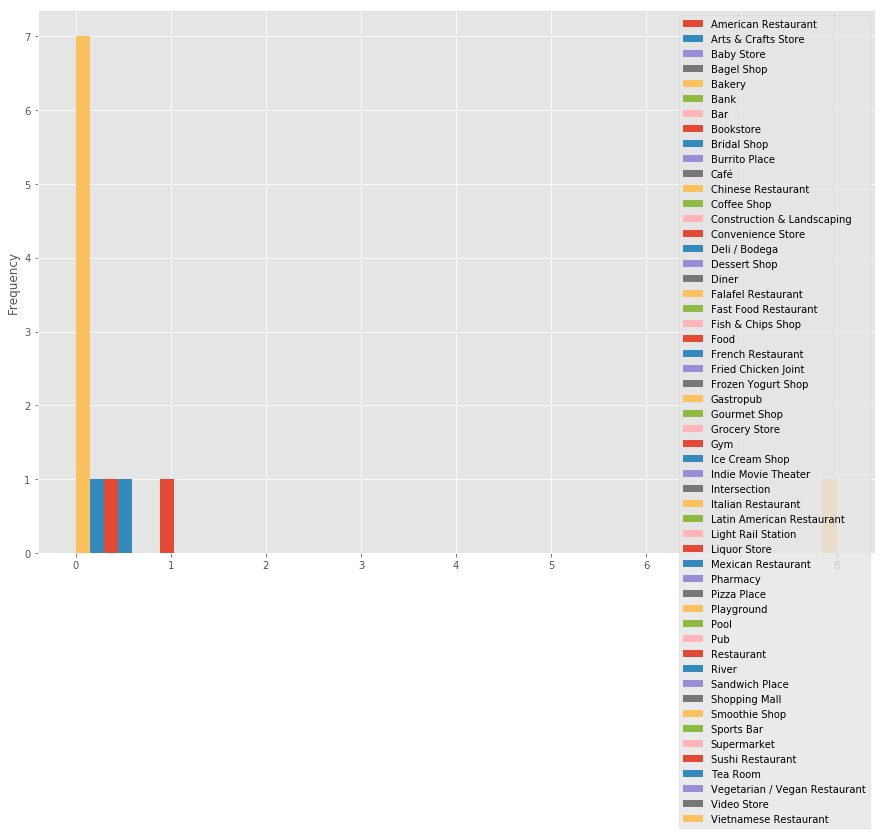

In [98]:
uk_stats.plot.hist(bins=uk_stats.shape[1], figsize=(15,10))
plt.legend(loc='upper right')
plt.show()

### Report venue frequency per neighbourhood with the highest population of Ukrainians

                 venue  freq
0          Coffee Shop  0.11
1        Grocery Store  0.06
2        Shopping Mall  0.06
3       Ice Cream Shop  0.06
4   Frozen Yogurt Shop  0.06
5  Fried Chicken Joint  0.06
6             Pharmacy  0.06
7          Pizza Place  0.06
8                Diner  0.06
9           Restaurant  0.06


                 venue  freq
0          Coffee Shop  0.14
1                  Pub  0.14
2  American Restaurant  0.07
3     Sushi Restaurant  0.07
4          Supermarket  0.07
5           Sports Bar  0.07
6          Pizza Place  0.07
7   Light Rail Station  0.07
8  Fried Chicken Joint  0.07
9    Convenience Store  0.07


                        venue  freq
0                 Coffee Shop  0.13
1         American Restaurant  0.07
2                    Pharmacy  0.07
3                  Restaurant  0.07
4              Sandwich Place  0.07
5  Construction & Landscaping  0.07
6                        Café  0.07
7        Fast Food Restaurant  0.07
8         Fried Chicken Joint  0.0

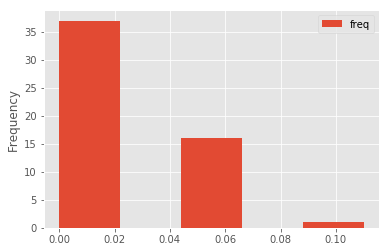

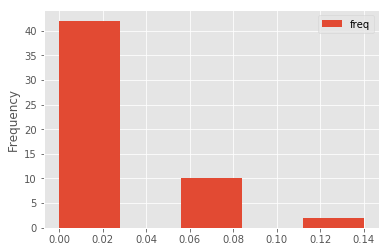

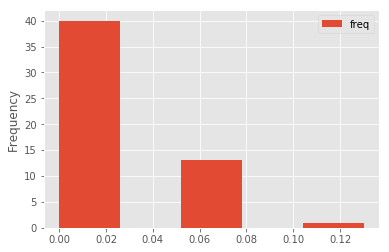

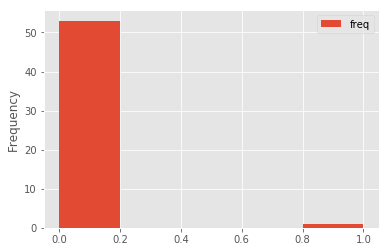

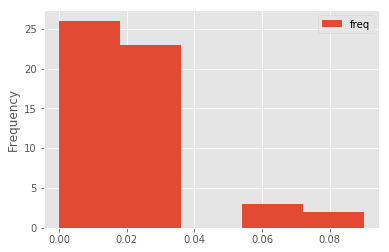

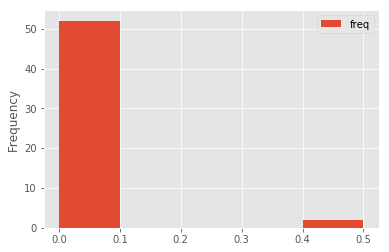

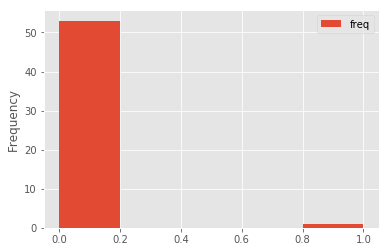

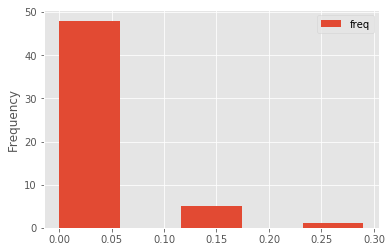

In [99]:
num_top_venues = 10

for hood in uk_grouped['Neighborhood']:
    temp = uk_grouped[uk_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp.plot.hist(bins=5)
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


In [100]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_least_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# List most common venues

In [103]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = uk_grouped['Neighborhood']

for ind in np.arange(uk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(uk_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bathurst Manor,Coffee Shop,Sandwich Place,Deli / Bodega,Ice Cream Shop,Pizza Place,Bridal Shop,Grocery Store,Video Store,Restaurant,Pharmacy
1,Deer Park,Pub,Coffee Shop,Vietnamese Restaurant,Bagel Shop,Convenience Store,Fried Chicken Joint,Light Rail Station,Pizza Place,American Restaurant,Supermarket
2,Humber Bay Shores,Coffee Shop,Restaurant,Fish & Chips Shop,Fast Food Restaurant,Gym,Construction & Landscaping,Liquor Store,Mexican Restaurant,Pharmacy,Fried Chicken Joint
3,Newtonbrook,Gym,Vietnamese Restaurant,Construction & Landscaping,Fried Chicken Joint,French Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Diner
4,Runnymede,Coffee Shop,Café,Sushi Restaurant,Italian Restaurant,Pizza Place,Gourmet Shop,Falafel Restaurant,Fish & Chips Shop,Food,French Restaurant
5,The Kingsway,River,Pool,Vietnamese Restaurant,Coffee Shop,Fried Chicken Joint,French Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant
6,West Deane Park,Bank,Vietnamese Restaurant,Construction & Landscaping,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant
7,Westmount,Pizza Place,Playground,Coffee Shop,Intersection,Sandwich Place,Chinese Restaurant,French Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant


### List least common venues - Lowest venue frequncy presents the highest returns for business with the least amount of competition

In [104]:
num_least_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of bottom venues
columns = ['Neighborhood']
for ind in np.arange(num_least_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = uk_grouped['Neighborhood']

for ind in np.arange(uk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_least_common_venues(uk_grouped.iloc[ind, :], num_least_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Bathurst Manor,American Restaurant,Gastropub,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
1,Deer Park,Gourmet Shop,Frozen Yogurt Shop,Gastropub,Video Store,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,River
2,Humber Bay Shores,Gourmet Shop,Video Store,Grocery Store,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Pizza Place
3,Newtonbrook,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
4,Runnymede,American Restaurant,Frozen Yogurt Shop,Video Store,Grocery Store,Ice Cream Shop,Intersection,Light Rail Station,Liquor Store,Mexican Restaurant,Playground
5,The Kingsway,American Restaurant,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
6,West Deane Park,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
7,Westmount,American Restaurant,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant


### Perform Neighbourhood Cluster Analysis

In [118]:
# set number of clusters
kclusters = 8

uk_grouped_clustering = uk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(uk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 5, 6, 2, 0, 3, 1, 4], dtype=int32)

### Merge the results with the clusters

In [119]:
uk_grouped_clustering

,American Restaurant,Arts & Crafts Store,Baby Store,Bagel Shop,Bakery,Bank,Bar,Bookstore,Bridal Shop,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Gastropub,Gourmet Shop,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy,Pizza Place,Playground,Pool,Pub,Restaurant,River,Sandwich Place,Shopping Mall,Smoothie Shop,Sports Bar,Supermarket,Sushi Restaurant,Tea Room,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.0,0.000000,0.055556,0.0,0.055556,0.055556,0.000000,0.000000,0.055556,0.055556,0.000000,0.000000,0.055556,0.000000
1,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.071429,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429
2,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.0,0.000000,0.066667,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.028571,0.028571,0.000000,0.000000,0.028571,0.028571,0.028571,0.000000,0.028571,0.085714,0.000000,0.085714,0.000000,0.000000,0.000000,0.028571,0.028571,0.028571,0.000000,0.028571,0.028571,0.028571,0.000000,0.000000,0.028571,0.028571,0.000000,0.028571,0.000000,0.028571,0.000000,0.057143,0.028571,0.000000,0.000000,0.000000,0.028571,0.057143,0.000000,0.0,0.028571,0.000000,0.0,0.028571,0.000000,0.028571,0.000000,0.000000,0.057143,0.028571,0.028571,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,

In [120]:
df_uk

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
49,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian
22,M3H,North York,Bathurst Manor,43.754328,-79.442259,14945,3187,34169,09.5,Russian
39,M2M,North York,Newtonbrook,43.789053,-79.408493,36046,4110,33428,08.8,Russian
67,M8V,Etobicoke,Humber Bay Shores,43.605647,-79.501321,10775,7588,39186,05.2,Russian
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
59,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian
74,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian
65,M4V,Central Toronto,Deer Park,43.686412,-79.400049,15165,10387,80704,01.1,Russian


In [121]:
df_uk_merged = df_uk
#df_uk_merged.drop([22], inplace=True)
# add clustering labels
df_uk_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language
49,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian
22,M3H,North York,Bathurst Manor,43.754328,-79.442259,14945,3187,34169,09.5,Russian
39,M2M,North York,Newtonbrook,43.789053,-79.408493,36046,4110,33428,08.8,Russian
67,M8V,Etobicoke,Humber Bay Shores,43.605647,-79.501321,10775,7588,39186,05.2,Russian
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian
59,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian
74,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian
65,M4V,Central Toronto,Deer Park,43.686412,-79.400049,15165,10387,80704,01.1,Russian


In [122]:
df_uk_merged['Cluster Labels'] = kmeans.labels_
#uk_grouped_clustering['Cluster Labels'] = kmeans.labels_
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_uk_merged = df_uk_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

df_uk_merged.head(10) # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
49,M9P,Etobicoke,Westmount,43.696319,-79.532242,5857,5932,35183,10.6,Ukrainian,7,American Restaurant,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
22,M3H,North York,Bathurst Manor,43.754328,-79.442259,14945,3187,34169,09.5,Russian,5,American Restaurant,Gastropub,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
39,M2M,North York,Newtonbrook,43.789053,-79.408493,36046,4110,33428,08.8,Russian,6,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
67,M8V,Etobicoke,Humber Bay Shores,43.605647,-79.501321,10775,7588,39186,05.2,Russian,2,Gourmet Shop,Video Store,Grocery Store,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Pizza Place
8,M9B,Etobicoke,West Deane Park,43.650943,-79.554724,4395,2063,41582,02.3,Ukrainian,0,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
59,M6S,West Toronto,Runnymede,43.651571,-79.484450,4382,5155,42635,02.2,Ukrainian,3,American Restaurant,Frozen Yogurt Shop,Video Store,Grocery Store,Ice Cream Shop,Intersection,Light Rail Station,Liquor Store,Mexican Restaurant,Playground
74,M8X,Etobicoke,The Kingsway,43.653654,-79.506944,8780,3403,110944,01.8,Ukrainian,1,American Restaurant,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
65,M4V,Central Toronto,Deer Park,43.686412,-79.400049,15165,10387,80704,01.1,Russian,4,Gourmet Shop,Frozen Yogurt Shop,Gastropub,Video Store,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,River


### Draw a map of the location most suitable for opening a new business venture targeting the demographic with the highest population of Ukrainians

In [128]:
# create map
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_uk_merged['Latitude'], df_uk_merged['Longitude'], df_uk_merged['Neighbourhood'], df_uk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        #color=rainbow[cluster-1],
        color='green',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Suggest the following business ventures based on the lowest frequncy of venues in the 1st cluster

In [129]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 0, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
8,Etobicoke,4395,2063,41582,02.3,Ukrainian,0,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy


### Suggest the following business ventures based on the lowest frequncy of venues in the 2nd cluster

In [390]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 1, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
74,Etobicoke,8780,3403,110944,01.8,Ukrainian,1,American Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Metro Station,Mexican Restaurant,Pet Store


### Suggest the following business ventures based on the lowest frequncy of venues in the 3rd cluster

In [391]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 2, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
59,West Toronto,4382,5155,42635,02.2,Ukrainian,2,American Restaurant,Frozen Yogurt Shop,Gift Shop,Video Store,Intersection,Light Rail Station,Liquor Store,Mexican Restaurant,Park,Pet Store


### Suggest the following business ventures based on the lowest frequncy of venues in the 4th cluster

In [392]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 3, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
49,Etobicoke,5857,5932,35183,10.6,Ukrainian,3,American Restaurant,Video Store,Indie Movie Theater,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Metro Station,Mexican Restaurant,Park


### Suggest the following business ventures based on the lowest frequncy of venues in the 5th cluster

In [394]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 4, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
67,Etobicoke,10775,7588,39186,05.2,Russian,4,Ice Cream Shop,Grocery Store,Video Store,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Metro Station,Park


### Suggest the following business ventures based on the lowest frequncy of venues in the 6th cluster

In [131]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 5, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
22,North York,14945,3187,34169,09.5,Russian,5,American Restaurant,Gastropub,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant


### Suggest the following business ventures based on the lowest frequncy of venues in the 7th cluster

In [396]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 6, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
39,North York,36046,4110,33428,08.8,Russian,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Suggest the following business ventures based on the lowest frequncy of venues in the 8th cluster

In [132]:
df_uk_merged.loc[df_uk_merged['Cluster Labels'] == 7, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]

,Borough,Population,Density (people/km2),Average Income,Percentage,Language,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
49,Etobicoke,5857,5932,35183,10.6,Ukrainian,7,American Restaurant,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant


## Recommendation Report: We recommend the following venues targeting the Ukrainian demographic

### Locations

In [135]:
# create map
map_clusters = folium.Map(location=[T_lat, T_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_uk_merged['Latitude'], df_uk_merged['Longitude'], df_uk_merged['Neighbourhood'], df_uk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        #color=rainbow[cluster-1],
        color='red',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List of recommended venues per each cluster

In [136]:
dict_suggested_venues = {}
for x in range(0, kclusters):
    df = df_uk_merged.loc[df_uk_merged['Cluster Labels'] == x, df_uk_merged.columns[[1,2]]]
    label = df.values[0][0] + '-' + df.values[0][1]
    df1 = df_uk_merged.loc[df_uk_merged['Cluster Labels'] == x, df_uk_merged.columns[[1] + list(range(5, df_uk_merged.shape[1]))]]
    dict_suggested_venues[label] = df1.values[0][7:]
    
rec_df = pd.DataFrame.from_dict(dict_suggested_venues, orient='index')
dict_rename_cols = {}
for i in range(0, 10):
    dict_rename_cols[i] = 'Venue {}'.format(i)
rec_df = rec_df.rename(columns=dict_rename_cols)
rec_df

,Venue 0,Venue 1,Venue 2,Venue 3,Venue 4,Venue 5,Venue 6,Venue 7,Venue 8,Venue 9
Etobicoke-West Deane Park,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
Etobicoke-The Kingsway,American Restaurant,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
Etobicoke-Humber Bay Shores,Gourmet Shop,Video Store,Grocery Store,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Pizza Place
West Toronto-Runnymede,American Restaurant,Frozen Yogurt Shop,Video Store,Grocery Store,Ice Cream Shop,Intersection,Light Rail Station,Liquor Store,Mexican Restaurant,Playground
Central Toronto-Deer Park,Gourmet Shop,Frozen Yogurt Shop,Gastropub,Video Store,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Intersection,River
North York-Bathurst Manor,American Restaurant,Gastropub,Gym,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant
North York-Newtonbrook,American Restaurant,Ice Cream Shop,Indie Movie Theater,Intersection,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant,Pharmacy
Etobicoke-Westmount,American Restaurant,Grocery Store,Gym,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Mexican Restaurant


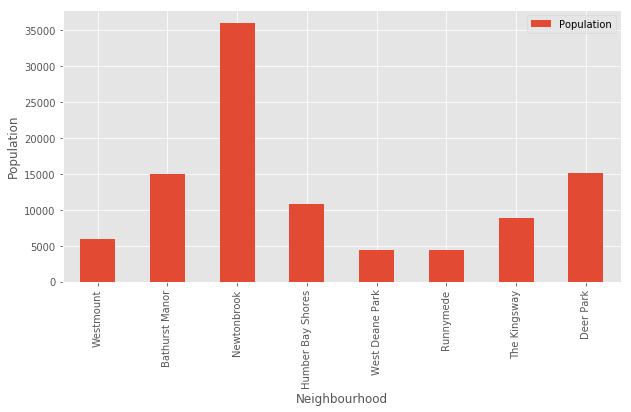

In [138]:
df_pop = df_uk[['Population', 'Neighbourhood']]
df_pop = df_pop.set_index('Neighbourhood')
df_pop.plot.bar(figsize=(10,5))
plt.ylabel('Population')
plt.show()

<Figure size 432x288 with 0 Axes>

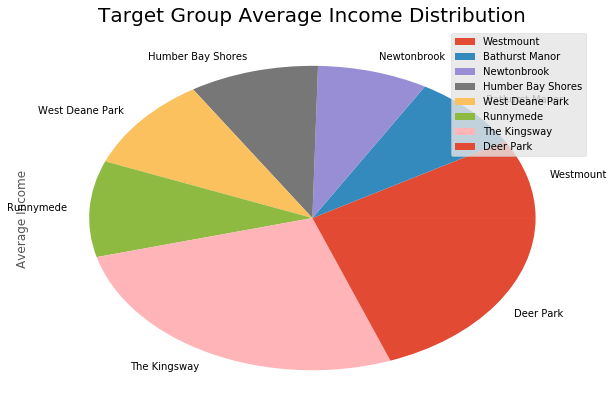

In [147]:

df_inc = df_uk[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')

fig = plt.figure()
ax = fig.add_subplot()

ax = df_inc.plot.pie(subplots=True, figsize=(10, 7), )

legend = plt.legend(frameon = 1, fontsize=8)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.yticks([])
plt.xticks([])
plt.ylabel= ''

plt.legend(loc='upper right')
plt.title('Target Group Average Income Distribution', fontsize=20)

plt.show()


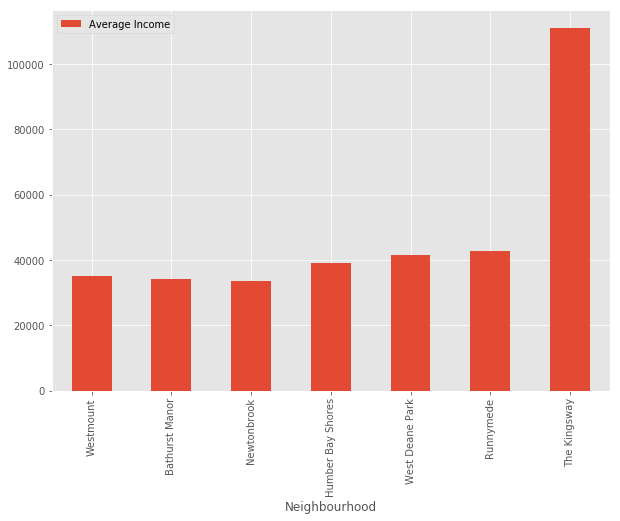

In [400]:
df_inc = df_uk[['Average Income', 'Neighbourhood']]
df_inc = df_inc.set_index('Neighbourhood')
df_inc = df_inc.apply(pd.to_numeric, errors='ignore')
df_inc.plot.bar(grid=True, figsize=(10,7))

# Thank you for reviwing my work!